In [ ]:
# DEV SCRIPT - DO NOT USE
import func_gen as gf
import func_ranked as rf
import func_clump as cf
import func_plot as pf

import os
import numpy as np
import re
from scipy.linalg import norm

In [46]:
# Setup
print("Running setup operations", flush=True)
config = gf.read_config("config.json")
gf.check_paths(config)

Running setup operations
(gen_funcs.read_config)
	Reading config
(gen_funcs.check_paths)


In [47]:
# Assign paths to variables
path_data = config["path_data"]
selected_figs = config["arr_figs"] # Folders to plot figures from. Edit config.json as e.g., ["Fig2_Fig4", "Fig6", "Fig7", "Fig8"] or ["old"]
paths_psliceout = gf.read_paths_psliceout(path_data, selected_figs)
path_out = config["path_out"]
path_ranked = config["path_ranked"]

In [48]:
# Load data
data_all = gf.iteratively_load_data(paths_psliceout)

(gen_funcs.iteratively_load_data)
	Loading data
		Loading file ./data/old/psliceout1.dat
		Loading file ./data/old/psliceout_dm1e-2_c_br_n_5E14-5E13.dat


In [49]:
# Rank particles
path_ranked = config["path_ranked"]
n_neighbors = config["const_N_neigh"]
fout_ranked = gf.iteratively_rank_neighbors(data_all, paths_psliceout, path_ranked, n_neighbors)

(gen_funcs.iteratively_rank_neighbors)
	Ranking particles
		Ranking file ./data/old/psliceout1.dat
(ranked_funcs.rank_neighbors)
	Checking if ranked file exists
		Ranked file ./output/ranked/ranked_100neigh_psliceout1.dat already exists. Skipping.
		Ranking file ./data/old/psliceout_dm1e-2_c_br_n_5E14-5E13.dat
(ranked_funcs.rank_neighbors)
	Checking if ranked file exists
		Ranked file ./output/ranked/ranked_100neigh_psliceout_dm1e-2_c_br_n_5E14-5E13.dat already exists. Skipping.


In [50]:
# Find clumps
coords_com_rankedf = gf.iteratively_delimit_clumps(config, fout_ranked, data_all)

(gen_funcs.iteratively_delimit_clumps)
	Using ranked data to get COM coordinates
		Processing file ranked_100neigh_psliceout1
(ranked_funcs.read_ranked)
	Reading in and reducing ranked file ./output/ranked/ranked_100neigh_psliceout1.dat
(ranked_funcs.get_com_coords)
	Finding centres of mass of disconnected clumps (threshold radius:  5.0)

			COM of clump 0: [ 10.9048    -15.3215     -0.0517648]
			Number of particles in raw search space: 10000000
			Minimum distance to COM: 6.1767e-06
			Number of particles in reduced search space: 579168
			Number of particles in preclump: 448037
			Crossing point: 4286
			Number of particles in postclump: 443116.0
			Number of particles in ranked data at the end: 726032

			COM of clump 1: [24.6408   38.8009    0.127862]
			Number of particles in raw search space: 9556884
			Minimum distance to COM: 3.8906e-05
			Number of particles in reduced search space: 199902
			Number of particles in preclump: 37236
			Crossing point: 546
			Number of particles

(gen_funcs.iteratively_plot_figures)
	Plotting figures
(lot_funcs.__init__)
	Plotting dust surface density for psliceout1
(lot_funcs.__init__)
	Plotting dust surface density for psliceout_dm1e-2_c_br_n_5E14-5E13


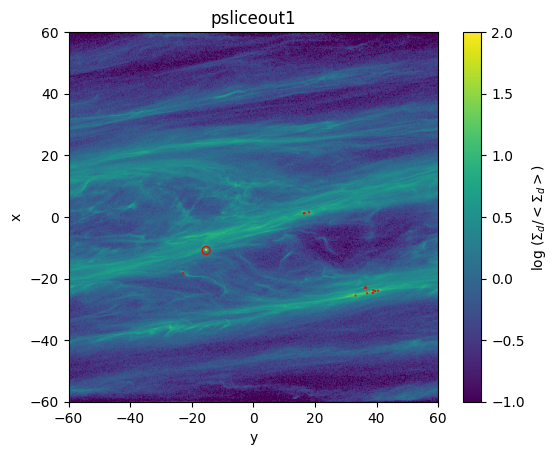

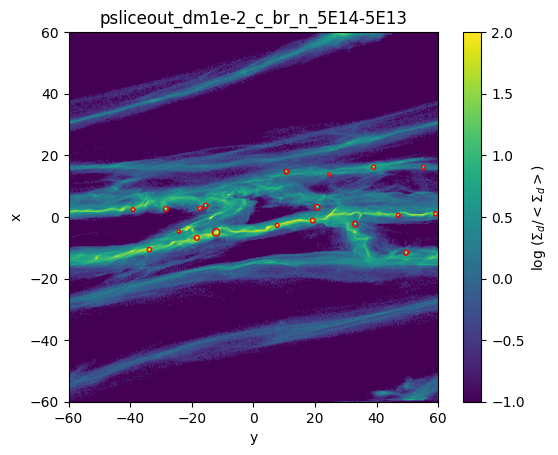

In [52]:
# Plotting
gf.iteratively_plot_figures(selected_figs, paths_psliceout, n_neighbors, data_all, coords_com_rankedf)

In [54]:
# # TESTS
# bla = 'ranked_100neigh_psliceout_dm1e-2_c_br_n_5E14-5E13'
# coords_com_rankedf[bla]['idxs_clump']
# densities = []
# for i in range(len(coords_com_rankedf[bla]['coords_com']['idx'])):
#     num = len(coords_com_rankedf[bla]['idxs_clump'][i])
#     density = num / (4 / 3 * np.pi * coords_com_rankedf[bla]['R_Hs'][i]**3)
#     densities.append(density)

In [55]:
# # TESTS
# [print(len(g)) for g in coords_com_rankedf[bla]['idxs_clump']]
# [print(R_H) for R_H in coords_com_rankedf[bla]['R_Hs']]
# # coords_com_rankedf[bla]['R_Hs']
# # coords_com_rankedf[bla]['coords_com']['idx']